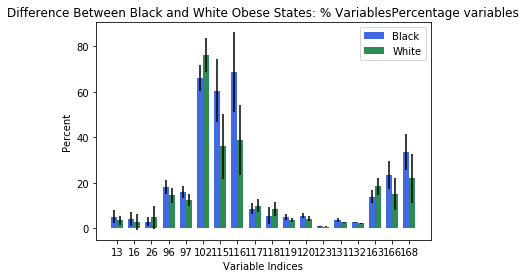

13 Households, no car & low access to store (%), 2010 0.00088918463893109867847430738407865646877326071262
16 SNAP households, low access to store (%), 2015 0.02670309085218816602669278381654294207692146301270
26 Seniors, low access to store (%), 2015 0.02883925808145022459672013326326123205944895744324
96 SNAP participants (% pop), 2012* 0.00000021380027418379265992536583489147528069906912
97 SNAP participants (% pop), 2016* 0.00000000353757092173652857016904452105293676922315
102 SNAP participants (% eligible pop), 2008* 0.00000000061952933709498458468694952739589006107668
115 Students eligible for free lunch (%), 2009 0.00000000000073232447970176903185805353523715951222
116 Students eligible for free lunch (%), 2014 0.00000000000002718097565550732212334148209872516589
117 Students eligible for reduced-price lunch (%), 2009 0.01866075914157578133356629734862508485093712806702
118 Students eligible for reduced-price lunch (%), 2014 0.00003771074527036706315304484538053486630815314129


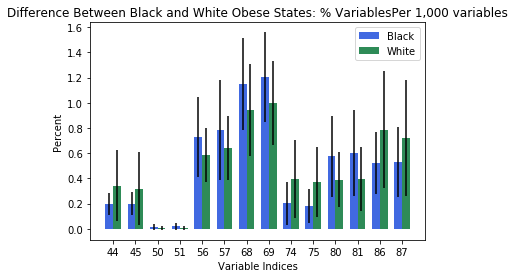

44 Grocery stores/1,000 pop, 2009 0.00308179993426908839168620879434001835761591792107
45 Grocery stores/1,000 pop, 2014 0.01419800167815815986060989928319031605497002601624
50 Supercenters & club stores/1,000 pop, 2009 0.01376739906269251398351904924766131443902850151062
51 Supercenters & club stores/1,000 pop, 2014 0.00374810598141051606185802924642302969004958868027
56 Convenience stores/1,000 pop, 2009 0.00713262871490806787261318433479573286604136228561
57 Convenience stores/1,000 pop, 2014 0.02739515977458032922053909885562461568042635917664
68 SNAP-authorized stores/1,000 pop, 2012 0.00605026062360378581034270339955583040136843919754
69 SNAP-authorized stores/1,000 pop, 2016 0.00399695267197549327503613980638874636497348546982
74 WIC-authorized stores/1,000 pop, 2008 0.00077540152990280338408252136517262442794162780046
75 WIC-authorized stores/1,000 pop, 2012 0.00023804594380011948008199484938529622013447806239
80 Fast-food restaurants/1,000 pop, 2009 0.0006804907404416573810101

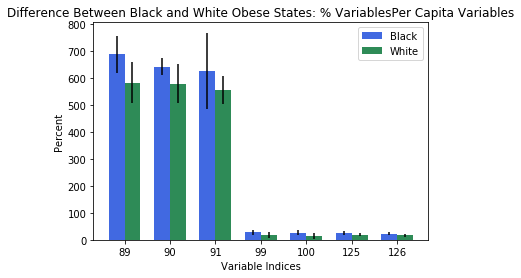

89 Expenditures per capita, fast food, 2007* 0.00000000056568950698384226103006031213978055394165
90 Expenditures per capita, fast food, 2012* 0.00000502605717841334818940263878817020781752944458
91 Expenditures per capita, restaurants, 2007* 0.00039769900101626031981363884604263603250728920102
99 SNAP benefits per capita, 2010 0.00000183839217441080106425917682633208727338569588
100 SNAP benefits per capita, 2015 0.00000011760746899447224593740382418693979360568846
125 WIC redemptions per capita, 2008 0.00000039590774079370884543592999660344133872058592
126 WIC redemptions per capita, 2012 0.00000374803023676100821601014055628464660685494891


In [3]:
import pandas as pd
import math
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import random
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats


df = pd.read_excel('/Users/ooganam/Desktop/individualprojects/foodsecurity/August2015.xls', sheet_name = None)
df.pop("Read_Me")
df.pop("Supplemental Data - County")
df.pop("Supplemental Data - State")
df.pop("LOCAL")
df.pop("INSECURITY")

x_categories = ["ACCESS", "ASSISTANCE", "HEALTH", "PRICES_TAXES", "RESTAURANTS", "STORES", "SOCIOECONOMIC"]
exclude = ["FIPS", "State", "County"]

def shuffle_in_place(array):
    array_len = len(array)
    assert array_len > 2, 'Array is too short to shuffle!'
    for index in range(array_len):
        swap = random.randrange(array_len - 1)
        array[[index,swap]] = array[[swap,index]]
    return array

countylist = [] #list of codes that correspond to different counties
variablenames = [] #list of variables in order that they appear in X matrix
variabledict = {}
X_all = [] #X matrix
Y_all = []

targetvar = "HEALTH"
#add all variable code names
for sheet in df:
    if sheet in x_categories:
        df[sheet].dropna(thresh = df[sheet].shape[1] - 20, inplace = True) #drop null values
        df[sheet].fillna(df[sheet].mean(), inplace=True)
        for variable in df[sheet].columns:
            if variable not in exclude:
                variablenames.append(variable) #add all variable names

#made dictionary mapping variable code names to actual variable names
for row in df["Variable List"].itertuples():
    if row.Code in variablenames:
        variabledict[row.Code] = row.Name

#RACE AND OBESITY

obesity = []
race = {}
for row in df["HEALTH"].itertuples():
    if row.PCT_OBESE_ADULTS13 > 33 and row.PCT_OBESE_ADULTS13 < 35:
        obesity.append(row.FIPS)
        
for row in df["SOCIOECONOMIC"].itertuples():
    if row.FIPS in obesity:
        race[row.FIPS] = (row.PCT_NHWHITE10, row.PCT_NHBLACK10)
    
whitemajority = [i for i in race if race[i][0] > 97]
blackmajority = [i for i in race if race[i][1] > 30]

from scipy.stats import ttest_ind
from random import randint

#add all county codes to a list
for sheet in df: #for each sheet
    if sheet in x_categories:  #if the sheet is one of the x variables
        temp = [] 
        for code in df[sheet]["FIPS"]:
            temp.append(code) 
        countylist.append(temp) 

finalcountylist = set.intersection(*map(set, countylist)) #select only those counties that are contained in every spreadsheet
countybool = {county:[] for county in finalcountylist} #map county codes to their corresponding data

for sheet in df:
    if sheet in x_categories: 
            for row in df[sheet].itertuples():
                if row.FIPS in countybool:
                    if row.FIPS in whitemajority or row.FIPS in blackmajority:
                        for element in row[4:]:
                            countybool[row.FIPS].append(element)

                            

blackaverages = []
whiteaverages = []
for county in countybool:
    temp = []
    for number in countybool[county]:
        temp.append(number)
    if county in blackmajority:
        blackaverages.append(temp)
    if county in whitemajority:
        whiteaverages.append(temp)
blackaverages = np.array(blackaverages)
whiteaverages = np.array(whiteaverages)
    
ttests = [ttest_ind(blackaverages[:,col], whiteaverages[:,col], equal_var = False) for col in range(len(blackaverages[0]))]

def containstring(string, list):
    for j in list:
        if j in string:
            return True
    return False


varkeywords = ["%", "1,000", "per capita", "rate"]
excluders = ["White", "Black", "Hispanic", "Asian", "American", "Multiracial", "change", "Hawaiian", "obesity", "diabetes"]
percentindices = []
thousandindices = []
percapitaindices = []

for counter, value in enumerate(ttests):
    var = variabledict[variablenames[counter]]
    if value[1] < .05 and value[1] != 0:
        if containstring(var, excluders) == False:
            if "%" in var or "rate" in var:
                percentindices.append(counter)
            if "1,000" in var:
                thousandindices.append(counter)
            if "per capita" in var:
                percapitaindices.append(counter)

import numpy as np
import matplotlib.pyplot as plt

allindices = [percentindices, thousandindices, percapitaindices]

for j in allindices:

    N = len(j)
    blackMeans = [np.mean(blackaverages[:,i]) for i in j]
    blackStd =   [np.std(blackaverages[:,i]) for i in j]

    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars

    fig = plt.figure()
    ax = fig.add_subplot(111)
    rects1 = ax.bar(ind, blackMeans, width, color='royalblue', yerr=blackStd)

    whiteMeans = [np.mean(whiteaverages[:,i]) for i in j]
    whiteStd =   [np.std(whiteaverages[:,i]) for i in j]
    rects2 = ax.bar(ind+width, whiteMeans, width, color='seagreen', yerr=whiteStd)

    # add some
    ax.set_ylabel('Percent')
    ax.set_xlabel('Variable Indices')
    string = ''
    if j == percentindices:
        string = "Percentage variables"
    elif j == thousandindices:
        string = "Per 1,000 variables"
    else:
        string = "Per Capita Variables"
    ax.set_title('Difference Between Black and White Obese States: % Variables' + string)
    ax.set_xticks(ind + width / 2)

    ax.set_xticklabels(j)

    ax.legend((rects1[0], rects2[0]), ('Black', 'White'))

    plt.show()

    for i in j:
        print(i, variabledict[variablenames[i]], format(ttests[i][1], '.50f'))